# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.21 which is incompatible.


In [2]:
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
import timeit

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [5]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

Set up QNetwork Class to Create Local and Target Value Functions

In [4]:
class QNetwork(nn.Module):
    """Value function template"""
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        return y

Set up Replay Buffer to Store Experiences

In [5]:
class ReplayBuffer():
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object"""
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from the memory buffer"""
        experiences = random.sample(self.memory, k=self.batch_size)
        # reshape and return experience components to device (CPU or GPU, set elsewhere)
        # from_numpy() creates pytorch tensor from numpy array
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of replay buffer memory"""
        return len(self.memory)

Set up Agent Class to Implement Learning Process

In [7]:
# Environment variables
BUFFER_SIZE = int(10**5) # replay buffer size
BATCH_SIZE = 64           # minibatch size
GAMMA = 0.99              # discount rate
TAU = .001                # weight for soft update of target q-network parameters
LR = .0005                # learning rate for backprop
UPDATE_EVERY = 4          # number of time steps between backward passes on local q-network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class Agent():
    def __init__(self, state_size, action_size, seed, eps=0.99, decay=0.005):
        """Initialize the learning agent.
        
        params:
            decay: (0, 1] epsilon is multplied by (1 - decay) after each episode. 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.eps = eps
        self.decay = decay
        
        #Initialize local and target q-networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        # Initialize optimizer to run gradient descent on local q-network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) # LR is environment variable
        
        # Get experiences for training from replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0 # Time step counter
        
    def step(self, state, action, reward, next_state, done):
        # Save step to replay buffer
        self.memory.add(state, action, reward, next_state, done)
        # print('step: {}'.format(self.t_step))
        # Run learning cycle (backprop) every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Make sure there are enough samples in buffer to fill batch
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
        # apply epsilon decay after each episode
        if done:
            self.eps = max(0.1, self.eps * (1 - self.decay))
        
    def act(self, state):
        """Get policy action given current state"""
        # unsqueeze() returns new tensor with extra dimension inserted at position
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # put qnetwork_local in eval mode (disable gradient computations)
        self.qnetwork_local.eval()
        with torch.no_grad():
            # get inference
            action_values = self.qnetwork_local(state)
        # put qnetwork_local back in train mode
        self.qnetwork_local.train()
        
        # select epsilon-greedy action from inference values
        if random.random() > self.eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        """Update parameters of local qnetwork using backward pass"""
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values for next states from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local network
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0-tau) * target_param.data)

Train banana agent

In [9]:
def run_episode(agent):
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations[0]            # get the current state
    state_size = len(state)
    score = 0  

    while True:
        # get next experience
        action = agent.act(state)                      # get policy-based action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        # print('reward: {}'.format(reward))
        done = env_info.local_done[0]                  # see if episode has finished

        # add experience to replay buffer & learn every UPDATE_EVERY steps
        agent.step(state, action, reward, next_state, done) 

        # increment score
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            return score

In [10]:
def train_banana_agent(agent, n_episodes=2000, max_t=2000):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        score = run_episode(agent)
        scores.append(score)
        scores_window.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [15]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, eps=0.99, decay=0.015)

start_time = timeit.default_timer()
scores = train_banana_agent(agent)
elapsed = timeit.default_timer() - start_time
print('training time: {}s'.format(elapsed))

Episode 100	Average Score: 1.27
Episode 200	Average Score: 7.15
Episode 300	Average Score: 10.61
Episode 400	Average Score: 11.55
Episode 472	Average Score: 13.04
Environment solved in 372 episodes!	Average Score: 13.04
training time: 376.223105733s


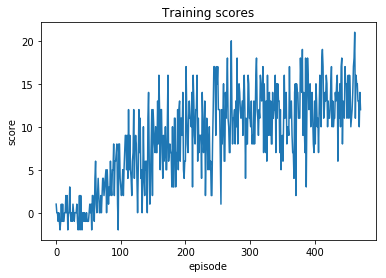

In [16]:
# Plot the score trend over episodes
plt.plot(scores)
plt.xlabel("episode")
plt.ylabel("score")
plt.title("Training scores")
plt.show()

In [17]:
# save model weights
w = agent.qnetwork_local.parameters()

weights = []
for elem in w:
    weights.append(elem.detach().numpy())

with open('weights.pkl', 'wb') as f:
    pickle.dump(weights, f)

In [18]:
env.close()